# Introduction

After the prevous benchmark, we saw that the fluctuation of result is very important. The main cause of this is that we buy N most performant ETF of a range ot time. But usually in trading, a peak is followed by a drop. What we can look at is possibilities to predict future based on past datas using RNNs. This is what we will do in this Notebook. Based on multiple paper, the best ratio is to use 6 moth as history and buy a Stock for a month.

First we will create a dataset with as input the 6 month past by week and try to predict the performance over the next month (or the probability that the trend remains positive)

# Preparation dataset

To have an important dataset, we will extract for every ETFs, several pieces of 26 weeks (even if there is overlap). If we use data only every 26 weeks, our dataset would be too small. Nevertheless, I won't use all weeks as input.

In [1]:
import gc
import datetime
import os
import pickle
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Let's start from the initial dataframe of price we prepared in the first Notebook

In [2]:
df = pd.read_csv("F:/data/trading/stat_history.csv", header =[0, 1], index_col=[0, 1])
df = df.reset_index()
df.columns = [' '.join(col).strip() for col in df.columns.values]

In [3]:
df2 = df.pivot(index='date', columns='symbol')
df2 = df2.swaplevel(i=0, j=1, axis=1)
etfs = np.unique(df2.columns.get_level_values(0))

df2.head()

symbol,AIA,ALTY,BBH,BND,BNDX,BOTZ,CACG,CATH,CFO,CIBR,...,VGSH,VIDI,VIGI,VMBS,VNQI,VUSE,VWOB,VYMI,XT,YLCO
,open min,open min,open min,open min,open min,open min,open min,open min,open min,open min,...,volume sum,volume sum,volume sum,volume sum,volume sum,volume sum,volume sum,volume sum,volume sum,volume sum
date,,,,,,,,,,,,,,,,,,,,,
2013-11-04,43.3307,NaN,82.0784,71.1781,45.7794,NaN,NaN,NaN,NaN,NaN,...,10004.0,1500.0,NaN,30464.0,84930.0,NaN,5431.0,NaN,NaN,NaN
2013-11-11,42.3476,NaN,77.4603,70.7654,45.6874,NaN,NaN,NaN,NaN,NaN,...,282308.0,95174.0,NaN,669417.0,364336.0,NaN,53033.0,NaN,NaN,NaN
2013-11-18,42.0103,NaN,78.8645,70.6425,45.4758,NaN,NaN,NaN,NaN,NaN,...,285759.0,7115.0,NaN,683192.0,924813.0,NaN,210623.0,NaN,NaN,NaN
2013-11-25,43.5923,NaN,81.4851,70.8357,45.8622,NaN,NaN,NaN,NaN,NaN,...,364820.0,6277.0,NaN,2015630.0,435346.0,NaN,88415.0,NaN,NaN,NaN
2013-12-02,43.7186,NaN,86.2812,70.9586,45.8438,NaN,NaN,NaN,NaN,NaN,...,269180.0,27825.0,NaN,771412.0,276871.0,NaN,52393.0,NaN,NaN,NaN


For the input, we will use a Standard Scaler to keep the variance we may have. The features used will be all we have above

For the output, we will use again the average between the average of high and low along the week and the ratio with be the monthly performance used as target (cented on 0)

To finish, in order to no share data between train and test set, we will use 4/5 of ETF for the train set and 1/5 for the test set. Even if we have overlapping weeks in training set, it cannot be on the one from the test set.

In [5]:
def process_X(X):
    a = X.iloc[:, :-4]/X.iloc[0, :-4]
    temp = X.iloc[:, -4:]
    b = (temp-temp.mean(axis=0))/temp.std(axis=0)
    return np.hstack((a,b))

def process_Y(Y):
    v = (Y["low mean"] + Y["high mean"])/2
    perf = v.iloc[-1]/v.iloc[0]
    return perf-1

In [10]:
X_train = []
X_test = []
y_train = []
y_test = []
np.random.seed(42)
for i, etf in enumerate(etfs):
    sub_df = df2[etf].dropna(axis=0, how="any")

    max_idx = len(sub_df) - 26 - 4
    if max_idx < 52: continue

    list_idx = np.arange(max_idx)
    np.random.shuffle(list_idx)
    for idx in list_idx[:max_idx//4]:
        X = sub_df.iloc[idx:idx+26]
        Y = sub_df.iloc[idx+26:idx+26+4]
        X2 = process_X(X)
        Y2 = process_Y(Y)
        if i%5 == 0:
            X_test.append(X2)
            y_test.append(Y2)
        else:
            X_train.append(X2)
            y_train.append(Y2)
        
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1, 1)
X_test = np.array(X_test)
y_test = np.array(y_test).reshape(-1, 1)

In [11]:
print("X_train shape :", X_train.shape)
print("y_train shape :", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

X_train shape : (5537, 26, 16)
y_train shape : (5537, 1)
X_test shape : (1391, 26, 16)
y_test shape : (1391, 1)


In [12]:
print(np.isnan(X_train).sum())
print(np.isnan(X_test).sum())
print(np.isnan(y_train).sum())
print(np.isnan(y_test).sum())

0
0
0
0


# Model

Now we have the dataset, let's create a model using LSTM's

### Classification perfs

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import optimizers
from keras import backend as K

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The first thing we can do is try to predict the probability to keep a positive ratio. As a result the dense layer will be completed by a sigmoid to have a probability of positive trend

In [14]:
K.clear_session()

model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(26, 16)))
model.add(LSTM(32, return_sequences=True))
# model.add(LSTM(64, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 26, 32)            6272      
_________________________________________________________________
lstm_2 (LSTM)                (None, 26, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 17,745
Trainable params: 17,745
Non-trainable params: 0
_________________________________________________________________


So now we have 3 layers of 32, 32, and 16 LSTMs followed by a simple Dense layer. This allow to have 17k parameters. Let's now fit in based on binary crossentropy using SGD Optimizer.

In [15]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer="Nadam", metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train>0,
          epochs=25,
          batch_size=150,
          validation_data=(X_test, y_test>0),
          verbose=0
         )

Now let's plot the history of learning

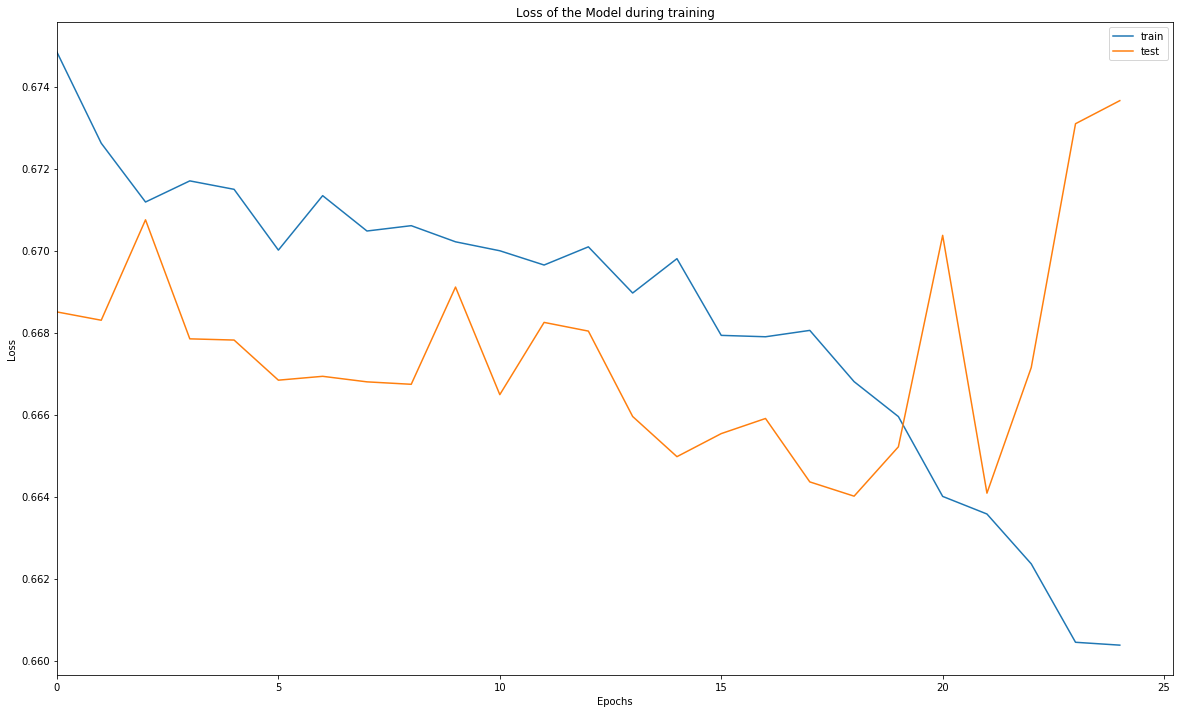

In [17]:
plt.figure(figsize=(20,12))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
# plt.ylim(0)
plt.xlim(0)
plt.title("Loss of the Model during training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

We can see an overfitting starting at Epoch 18. The loss at this stage is important so the model didn't learned anything... This is also visible with the accuracy

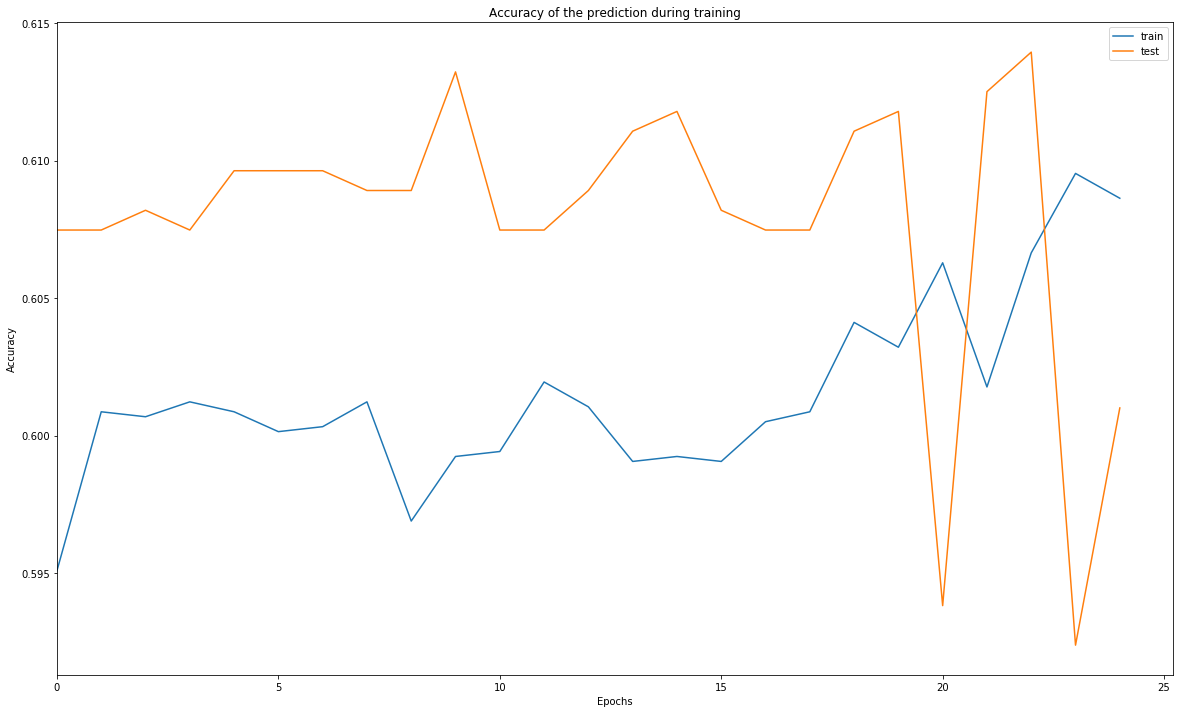

In [18]:
plt.figure(figsize=(20,12))
plt.plot(history.history["acc"], label="train")
plt.plot(history.history["val_acc"], label="test")
plt.legend()
# plt.ylim(0)
plt.xlim(0)
plt.title("Accuracy of the prediction during training")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

Nearly no learning. I tried several changes (more layers, other optimizer, other learning rate, longer training) but with no good results. Let's have a look at regression. 

### Regression

For this model, we can use MSE, MAE or a mix which is Huber Loss.

In [19]:
import tensorflow as tf

def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)

In [20]:
K.clear_session()

model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(26, 16)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1, activation=None))  # <= removed to have regression

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 26, 32)            6272      
_________________________________________________________________
lstm_2 (LSTM)                (None, 26, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 17,745
Trainable params: 17,745
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss="mae", optimizer="Nadam", metrics=['mae', "mse", huber_loss]) 
history_mae = model.fit(X_train, y_train,
              epochs=25,
              batch_size=150,
              validation_data=(X_test, y_test),
              verbose=0
             )

with open("F:/data/trading/train_pickle/mae.pkl", "wb") as f:
    pickle.dump(history_mae.history, f)

In [22]:
model.compile(loss="mse", optimizer="Nadam", metrics=['mae', "mse", huber_loss]) 
history_mse = model.fit(X_train, y_train,
              epochs=25,
              batch_size=150,
              validation_data=(X_test, y_test),
              verbose=0
             )

with open("F:/data/trading/train_pickle/mse.pkl", "wb") as f:
    pickle.dump(history_mse.history, f)

In [23]:
model.compile(loss=huber_loss, optimizer="Nadam", metrics=['mae', "mse", huber_loss]) 
history_huber = model.fit(X_train, y_train,
              epochs=25,
              batch_size=150,
              validation_data=(X_test, y_test),
              verbose=0
             )

with open("F:/data/trading/train_pickle/huber.pkl", "wb") as f:
    pickle.dump(history_huber.history, f)

In [24]:
with open("F:/data/trading/train_pickle/mae.pkl", "rb") as f:
    history_mae = pickle.load(f)

with open("F:/data/trading/train_pickle/mse.pkl", "rb") as f:
    history_mse = pickle.load(f)
    
with open("F:/data/trading/train_pickle/huber.pkl", "rb") as f:
    history_huber = pickle.load(f)

First we can plot all loss... The problem is that we won't be able to compare them as they use different loss functions

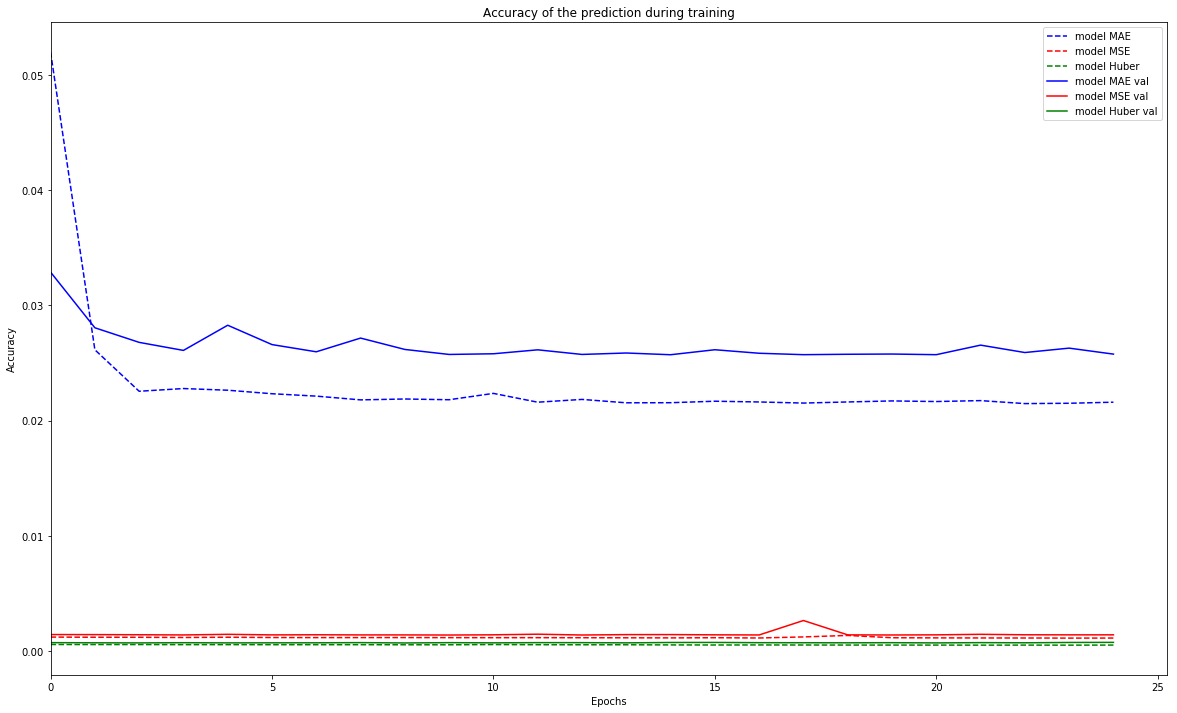

In [25]:
plt.figure(figsize=(20,12))
plt.plot(history_mae["loss"], label="model MAE", c="b", linestyle="--")
plt.plot(history_mse["loss"], label="model MSE", c="r", linestyle="--")
plt.plot(history_huber["loss"], label="model Huber", c="g", linestyle="--")
plt.plot(history_mae["val_loss"], label="model MAE val", c="b")
plt.plot(history_mse["val_loss"], label="model MSE val", c="r")
plt.plot(history_huber["val_loss"], label="model Huber val", c="g")
plt.legend()
# plt.ylim(0)
plt.xlim(0)
plt.title("Accuracy of the prediction during training")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

But I also tracked all other metrics for every models to be able to compare them

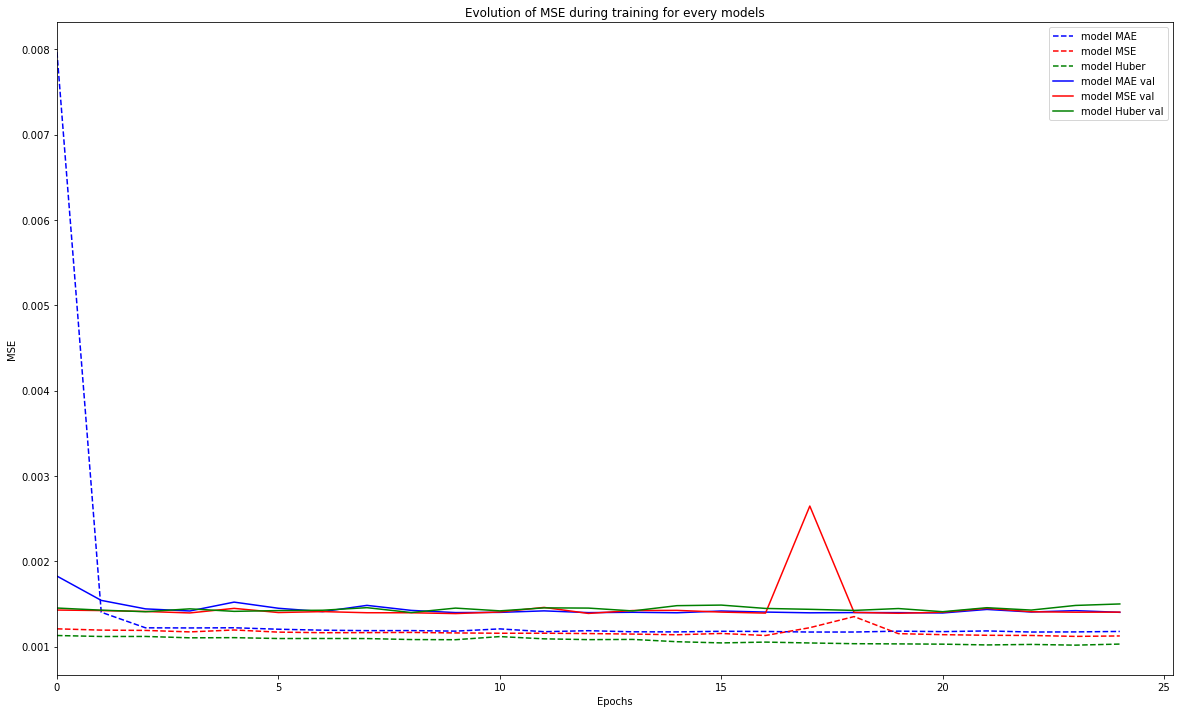

In [26]:
plt.figure(figsize=(20,12))
plt.plot(history_mae["mean_squared_error"], label="model MAE", c="b", linestyle="--")
plt.plot(history_mse["mean_squared_error"], label="model MSE", c="r", linestyle="--")
plt.plot(history_huber["mean_squared_error"], label="model Huber", c="g", linestyle="--")
plt.plot(history_mae["val_mean_squared_error"], label="model MAE val", c="b")
plt.plot(history_mse["val_mean_squared_error"], label="model MSE val", c="r")
plt.plot(history_huber["val_mean_squared_error"], label="model Huber val", c="g")
plt.legend()
# plt.ylim(0)
plt.xlim(0)
plt.title("Evolution of MSE during training for every models")
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.show()

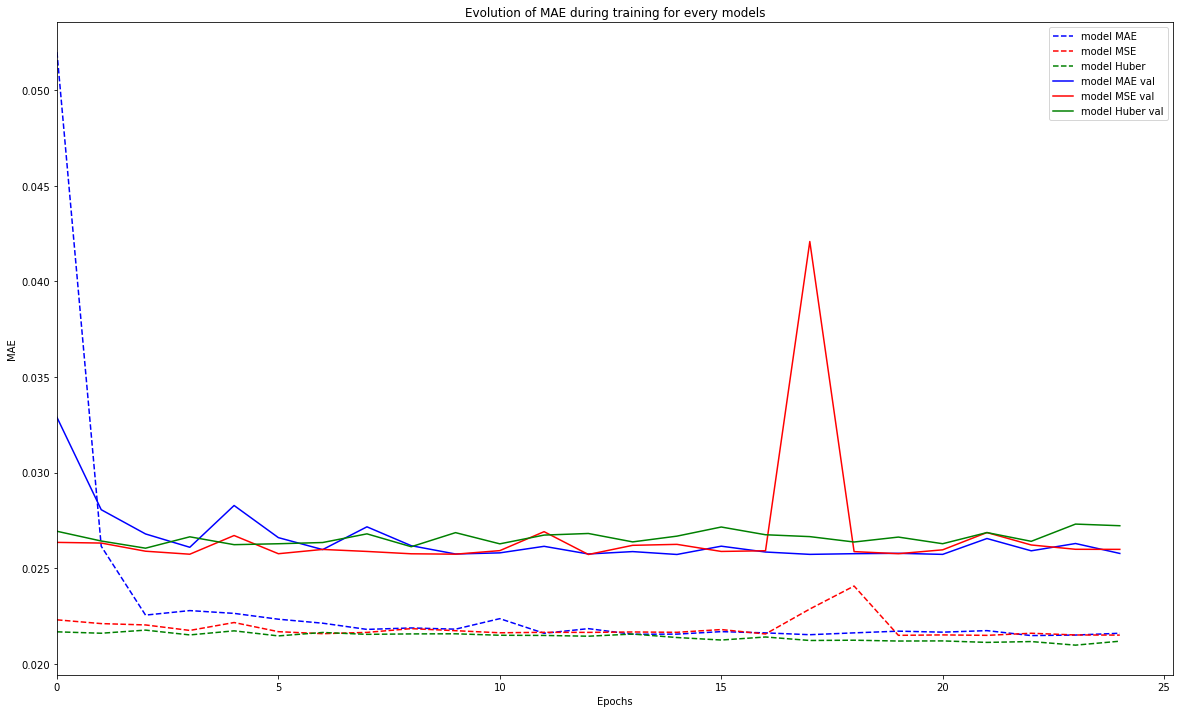

In [27]:
plt.figure(figsize=(20,12))
plt.plot(history_mae["mean_absolute_error"], label="model MAE", c="b", linestyle="--")
plt.plot(history_mse["mean_absolute_error"], label="model MSE", c="r", linestyle="--")
plt.plot(history_huber["mean_absolute_error"], label="model Huber", c="g", linestyle="--")
plt.plot(history_mae["val_mean_absolute_error"], label="model MAE val", c="b")
plt.plot(history_mse["val_mean_absolute_error"], label="model MSE val", c="r")
plt.plot(history_huber["val_mean_absolute_error"], label="model Huber val", c="g")
plt.legend()
# plt.ylim(0)
plt.xlim(0)
plt.title("Evolution of MAE during training for every models")
plt.ylabel("MAE")
plt.xlabel("Epochs")
plt.show()

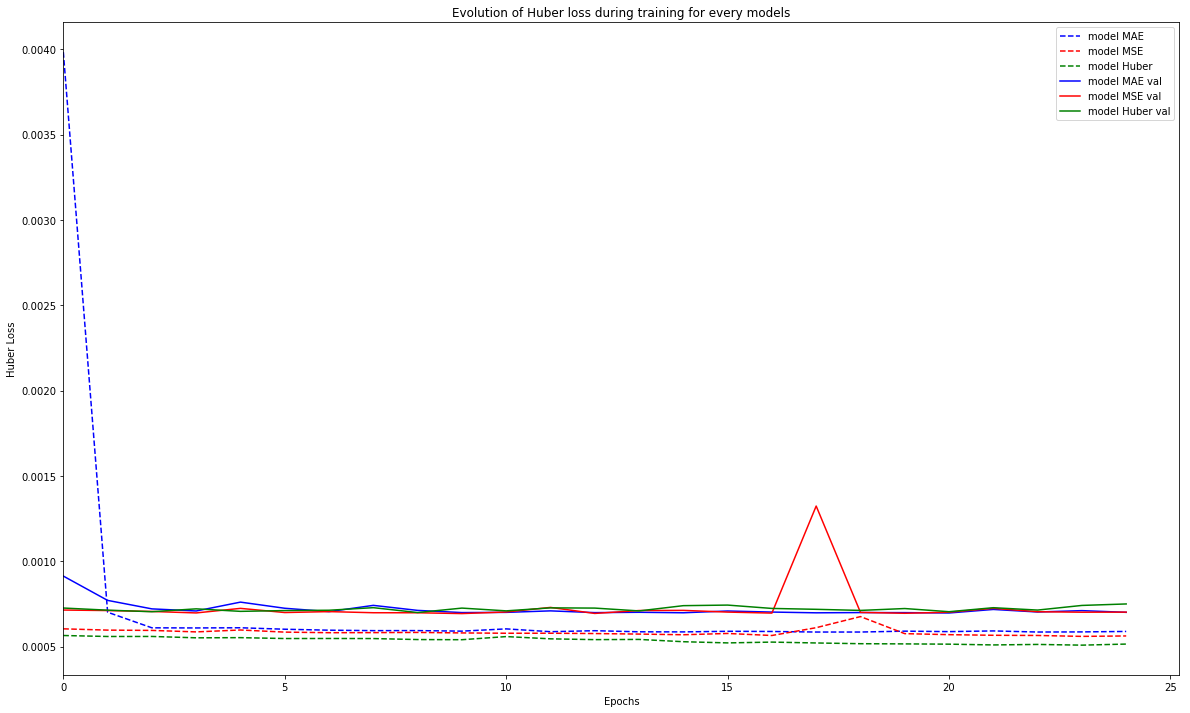

In [28]:
plt.figure(figsize=(20,12))
plt.plot(history_mae["huber_loss"], label="model MAE", c="b", linestyle="--")
plt.plot(history_mse["huber_loss"], label="model MSE", c="r", linestyle="--")
plt.plot(history_huber["huber_loss"], label="model Huber", c="g", linestyle="--")
plt.plot(history_mae["val_huber_loss"], label="model MAE val", c="b")
plt.plot(history_mse["val_huber_loss"], label="model MSE val", c="r")
plt.plot(history_huber["val_huber_loss"], label="model Huber val", c="g")
plt.legend()
# plt.ylim(0)
plt.xlim(0)
plt.title("Evolution of Huber loss during training for every models")
plt.ylabel("Huber Loss")
plt.xlabel("Epochs")
plt.show()

Based on those graphs, we don't see any perfect model but the one using Huber Loss or MSE seems better as it penalize a lot the bigger mistake. This will ease the model to have variance in the output. Let's now train it again to evaluate it

In [29]:
K.clear_session()

model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(26, 16)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1, activation=None))  # <= removed to have regression

model.summary()

model.compile(loss="mse", optimizer="Nadam", metrics=["mse"]) 
history = model.fit(X_train, y_train,
              epochs=25,
              batch_size=150,
              validation_data=(X_test, y_test),
              verbose=0
             )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 26, 32)            6272      
_________________________________________________________________
lstm_2 (LSTM)                (None, 26, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 17,745
Trainable params: 17,745
Non-trainable params: 0
_________________________________________________________________


Now let's predict performances for the test set. We will be able to compare it to real perfs.

In [30]:
y_pred = model.predict(X_test)

What we can first check is that the prediction is at least more accurate than a random model to predict a positive of negative performance

In [31]:
(y_test > 0).mean()

0.6074766355140186

Based on the dataset balance, a random model would have an accuracy of 60%. Let's look at how much we have now

In [32]:
((y_pred > 0) == (y_test > 0)).mean()

0.6024442846872753

Hum, only 60% of the prediction are correct which is what a random model would predict... Really not usefull :(. To understand it, let's compare prediction vs reality on few points

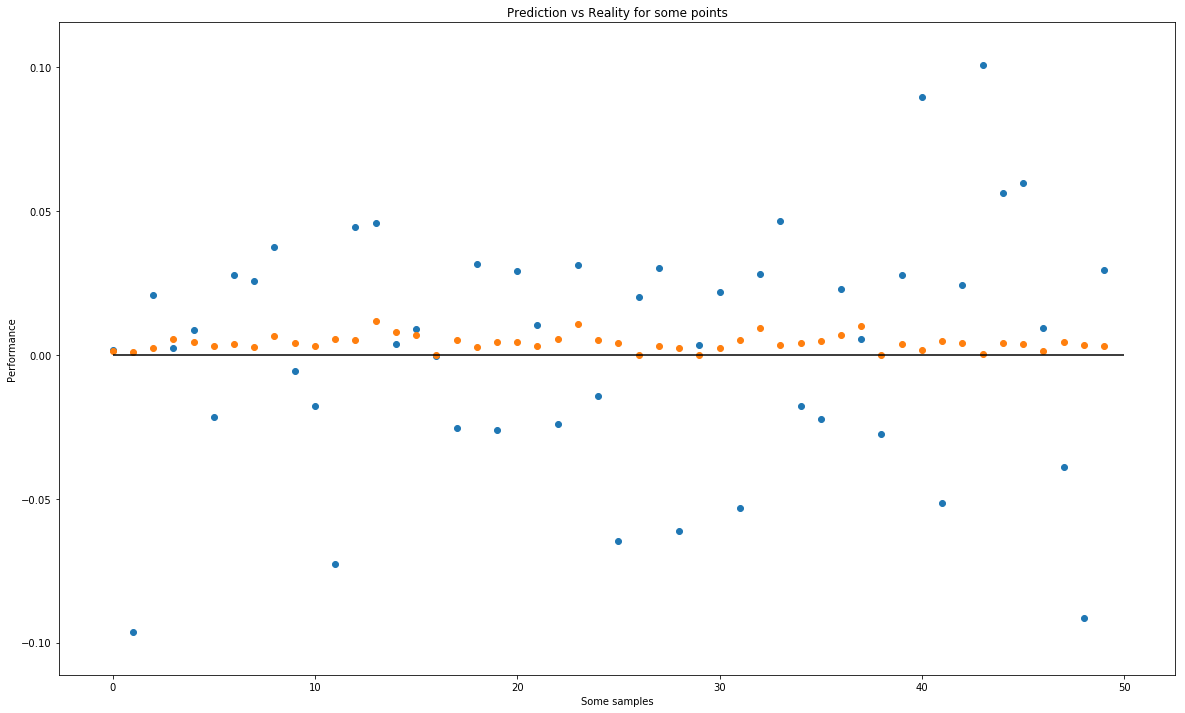

In [35]:
n = 50
X = range(50)
Y1 = y_test[:50]
Y2 = y_pred[:50]
plt.figure(figsize=(20,12))
plt.scatter(X, Y1)
plt.scatter(X, Y2)
plt.hlines(0, 0, 50)
plt.title("Prediction vs Reality for some points")
plt.ylabel("Performance")
plt.xlabel("Some samples")
plt.show()

We can see that for some good performacens, our prediction is sligly higher and for negative ones it's close to 0 but nearly never negative. This is mainly because the model doesn't find a particular pattern and remain around the mean. This is more visible on the distribution

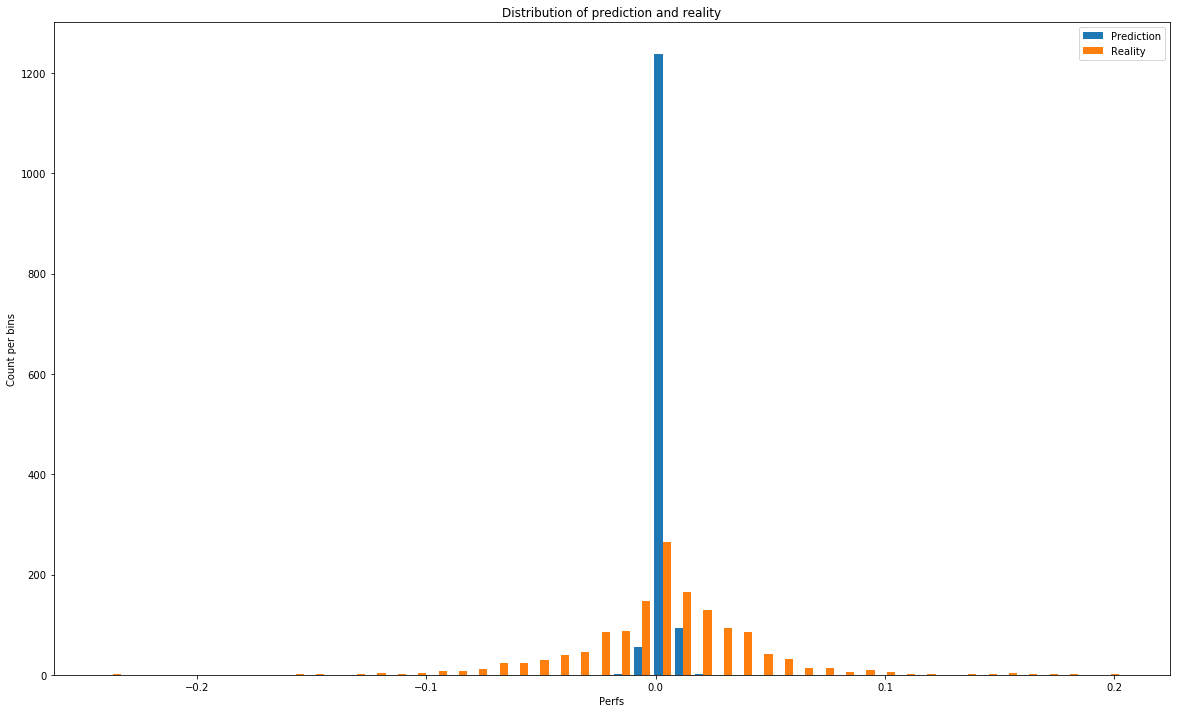

In [42]:
plt.figure(figsize=(20,12))
plt.hist([y_pred, y_test], bins=50, label=["Prediction", "Reality"])
plt.legend()
plt.title("Distribution of prediction and reality")
plt.ylabel("Count per bins")
plt.xlabel("Perfs")
plt.show()

# Conclusion

Unfortunately, even if I tried multiple adjustment, I don't have any model providing a good result to be used in our model. We don't have anought data to try deeper/wider model without huge overfitting (which is already the case). 

I will still keep this in memory in case I find a trick but so far, the data is not sufficient to learn something and the random part of market Stock doesn't help too. It's not magic.